# Programming Assignment 4 -
# Korean Question Answering · Generation w/ Hugging Face🤗

해당 과제는 고려대학교 딥러닝 학회 AIKU의 학회원 조혜진, 김예랑이 직접 제작하였습니다. 상업적 용도로의 사용을 절대 금합니다.

안녕하세요, AIKU 학회원 여러분! 드디어 길다면 길고 짧다면 짧은 DeepIntoDeep 프로그래밍 과제의 반환점을 돌았는데요.

프로그래밍 과제 1, 2, 3으로 인해 많이 지치셨을 여러분을 위해, 이번 과제는 원리보다는 활용적인 부분을 중심으로 구성해 보았습니다. 아마 앞선 과제들보다는 쉽게 느끼실 수도 있을 거예요 :)

이번 과제는 9강에서 배웠던 **pretrained language model**을 활용해 10강에서 배운 **Question Answering task**와 **Question Generation task**를 직접 해 보는 시간을 가질 것입니다.

그 과정에서, **Hugging Face**라는 새로운 tool을 도입할 것인데요. pytorch만 배운 입장에서는 생소할 수도 있지만, 익숙해진다면 자연어 처리뿐만 아니라 전반적인 딥러닝 task에서 유용하게 쓸 수 있을 거예요!😊

Pretrained language model로는 Encoder-only 모델인 `BERT`와 Encoder-Decoder 모델인 `BART` 두 가지를 사용할 예정인데요. (9강에서 배웠으니 많이 익숙할 거예요!) 두 모델을 이용해서 각각 Question Answering과 Question generation 두 task를 수행해보고, 모델의 장단점을 직접 체감하는 시간을 가질 것입니다.

그러면 시작해 봅시다!

※ 이 과제는 총 **8문제**로 구성되어 있습니다.

### Hugging Face🤗란 무엇일까요?

**Hugging Face**는 자연어 처리(NLP)와 머신 러닝에 특화된 유용한 도구들을 개발하는 회사입니다. Hugging Face에서 개발한 라이브러리를 이용하면 토크나이저, 모델(Transformer), 학습(Trainer) 등과 같은 작업을 코드 몇 줄만으로 매우 간단하게 수행할 수 있습니다.

Hugging Face의 또 다른 장점은 Pytorch와 Tensorflow 두 라이브러리에 모두 호환이 된다는 것입니다. 이로써 라이브러리에 구애받지 않고 모델을 학습시킬 수 있게 되었습니다.

이 과제를 수행하시는 분들이 아직까지 Pytorch의 training method에 익숙하지 않다는 가정 하에, 이번 시간에는 Hugging Face의 Trainer나 Datasets같은 라이브러리는 따로 사용하지 않을 예정입니다. 대신, Hugging Face에서 가장 유명한 **Transformer** 라이브러리를 이용하여 모델을 로드하고 학습시킬 예정이니, 잘 따라와 주세요!

## 1. 준비

## 1-1. 라이브러리 임포트
필요한 라이브러리를 설치/임포트합니다.

In [ ]:
# koBERT tokenizer용 라이브러리
!pip install transformers
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install torch
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf' # koBERT tokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292699 sha256=0c212dabf5a1be6ec1ee7816f3a95ab52d4cea779b3c13fbeeb481279b4711c4
  Stored in directory: /root/.cache/pip/wheels/2d/cc/dc/7ec84dced25f738b8be400101abb67e4b50c905090a51017e4
Successfully built gluonnlp
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
import numpy as np
import logging
import json
import pandas as pd

import torch
from torch import nn,Tensor
import torch.nn.functional as F
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup

from tqdm import tqdm

# for koBART
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

# for koBERT
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertForQuestionAnswering

## 1-2. GPU 확인

학습에 cpu를 사용할지, gpu를 사용할지 보여주는 코드입니다. 설정하신 런타임 유형에 따라 나오는 값이 다릅니다! 본 과제를 수행하실 때는, Assignment 2를 수행하셨을 때와 비슷하게 **train 전의 코드는 런타임 유형을 CPU로 설정** 후 작업해주시고, **train 코드를 실행할 때만 런타임 유형을 GPU로 변경**하여 실행해 주세요! (Dataset이 큰 편이기 때문에, 1 Epoch에 대략 15분 정도 소요됩니다. 좋은 결과를 위해서는 최소 3 Epoch 이상 Train 해보실 것을 권장하기 때문에, GPU 사용량을 최대한 아껴 두시는 것을 추천드립니다.)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: ', device)

using device:  cuda


## 1-3. 드라이브 마운트 (선택 사항)
Google Drive를 마운트해서 colab 노트북에 접근 가능하게 만들어주세요. 해당 과제를 할 때는 굳이 안하셔도 됩니다.

In [ ]:
# 지난 과제에서도 했던 과정이기 때문에 똑같이 Google Drive를 Mount해주시면 됩니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1-4a. Dataset 다운로드 (Colab 환경인 경우만)
아래 코드를 실행시켜 다운로드 해 주세요.

In [ ]:
!wget https://korquad.github.io/dataset/KorQuAD_v1.0_train.json
!wget https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json

--2023-08-11 04:38:38--  https://korquad.github.io/dataset/KorQuAD_v1.0_train.json
Resolving korquad.github.io (korquad.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to korquad.github.io (korquad.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38527475 (37M) [application/json]
Saving to: ‘KorQuAD_v1.0_train.json’

KorQuAD_v1.0_train. 100%[===================>]  36.74M  --.-KB/s    in 0.09s   

2023-08-11 04:38:40 (393 MB/s) - ‘KorQuAD_v1.0_train.json’ saved [38527475/38527475]

--2023-08-11 04:38:40--  https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json
Resolving korquad.github.io (korquad.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to korquad.github.io (korquad.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3881058 (3.7M) [application/json]
Saving to: ‘KorQuAD_v1.0_dev.json’

KorQuAD_v1.0_dev.js 100%[======

In [ ]:
# 수정하지 말고, 실행시켜 주세요.
DATA_DIR = "/content/"

##1-4b. Dataset 다운로드 (로컬 환경인 경우만)
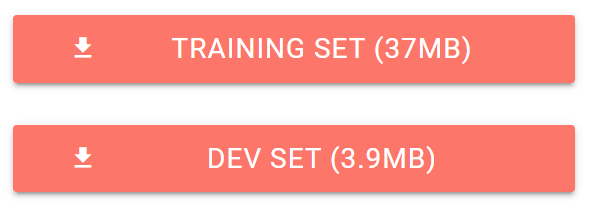

[링크](https://korquad.github.io/KorQuad%201.0/)에 접속하여 train와 dev 데이터셋을 다운로드 받아 줍니다. 그 후 **파일명을 변경하지 말고** 임의의 경로에 저장한 후 아래 `data_dir`을 train과 dev 데이터셋이 있는 경로로 설정 해 주세요.

※ 주의: 상대 경로로 설정 해 주세요.

In [ ]:
# 데이터셋이 있는 경로로 바꾸어 주세요.
DATA_DIR = "/content/"

# 2. 데이터 확인
환경 세팅이 끝났습니다! 이제 저희가 다운로드 받은 데이터를 확인하고 처리할 시간을 가질 것입니다.

### KorQuAD 데이터셋이란?
Stanford Question Answering Dataset(SQuAD)을 벤치마킹하여, 한국어 Machine Reading Comprehension을 위해 만든 데이터셋 입니다. 질문과 답변, 해당 답변이 있는 위치(숫자)로 이루어져 있습니다. 총 60,407개의 Taining set, 5,774개의 Dev set으로 구성되었습니다.

## 2-1. 데이터셋 로드
기존 json 파일은 우리 task에 적용하기에 구조가 적합하지 않아서, `preprocessing` 함수를 이용해 구조를 바꾸어 list로 만들어 준 후 그것을 다시 `pandas` DataFrame으로 바꿔줄 것입니다.

(물론 list 형태 그 자체로도 충분히 pytorch의 Dataset에 사용될 수 있습니다. 순전히 데이터를 잘 살펴보기 위해 치환했을 뿐입니다.)

json 파일을 미리 지정해둔 경로로부터 읽어와서, 위에서 지정한 전처리 함수에 넣어 봅시다! 여기서 파일의 형태에 주의해야 합니다.

json - JSON 데이터는 키/값 쌍으로 작성됩니다. 키와 값은 중간에 콜론(:)으로 구분되며 왼쪽에는 키, 오른쪽에는 값이 있습니다. 다른 키/값 쌍은 쉼표(,)로 구분됩니다. 키는 “name"과 같이 큰따옴표로 묶인 문자열입니다.(출처:docs.fileformat)

csv - CSV(영어: comma-separated values)는 몇 가지 필드를 쉼표(,)로 구분한 텍스트 데이터 및 텍스트 파일이다. (출처 - wikipedia)

DataFrame - pandas 라이브러리에서 제공하는 세 가지 데이터 구조(1차원 serial, 2차원 dataframe, 3차원 panel) 중에서 2차원 데이터 구조에 해당하는 구조로, row,column, series로 구성된다. (출처 - wikipedia)

In [ ]:
def preprocessing(js):
  processed = []

  for article in js:
    for paragraph in article["paragraphs"]:
        context = paragraph["context"]
        for qa in paragraph["qas"]:
            question = qa["question"]
            id_ = qa["id"]
            # answers = [answer["text"] for answer in qa["answers"]]
            # 원본 데이터에서도 list가 여러개인 것처럼 되어 있지만 검증 결과 답이 여러개인 dataset은 존재X
            answer = qa["answers"][0]["text"]
            answer_start = qa["answers"][0]["answer_start"]

            processed.append({"question": question, "context": context, "answer": answer, "answer_start": answer_start})

  return processed

### 문제 0.

우리가 다운받은 데이터셋은 키/값 쌍으로 구성된 딕셔너리를 요소로 가지고 있는 json 파일입니다. 그런데, 이번 모델을 학습시키기 위해서는 이를 dataframe 형태로 바꾸어 주어야 합니다. 이 때 사용하는 pandas 라이브러리의 함수가 무엇인지, 아래 링크를 보고 참고해서 빈칸을 채워 주세요!

[참고 링크](https://dataanalytics.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%ED%8C%90%EB%8B%A4%EC%8A%A4-pandas-%ED%95%A8%EC%88%98-%EC%A0%95%EB%A6%AC-%EB%AA%A8%EC%9D%8C)

In [ ]:
# train dataset
# json 파일을 로드합니다.
with open(os.path.join(DATA_DIR, 'KorQuAD_v1.0_train.json')) as f:
    js = json.loads(f.read())
js = js['data']

df = preprocessing(js)

#################################################################################################
# TODO :list 형태의 데이터셋을 DataFrame으로 바꾸어 줍니다.                                     #
#################################################################################################
df =

# 데이터의 양이 많은 관계로 절반만 학습합니다.
train = df[:30210]
# 데이터프레임을 출력하여 확인합니다.
train.head()

,question,context,answer,answer_start
0,바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,교향곡,54
1,바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,1악장,421
2,바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,베토벤의 교향곡 9번,194
3,1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,파우스트,15
4,파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,합창교향곡,354


head() 함수는 pandas 라이브러리에서 제공하는, pandas 데이터의 확인을 위한 함수입니다. head()는 해당 dataframe에서 맨 처음 n줄의 데이터를 출력해 줍니다. 만약, n을 지정하지 않으면 n=5로 가정하고 출력합니다. **만약 전처리가 제대로 되었다면 자료의 index, 자료의 question, context, answers에 해당하는 내용이 표 형태로 출력**되어야 합니다.

KorQuad의 test dataset은 정답(Ground Truth)이 없으므로, train dataset 중 일부를 가져와 test dataset으로 사용하겠습니다.

In [ ]:
test = df.iloc[-1000:]

## 2-2. 데이터셋 살펴보기
해당 데이터셋은 `context`, `question`, `answer`, `answer_start` 총 네 개의 컬럼으로 이루어져 있습니다. 각 컬럼의 역할은 다음과 같습니다.
- `context`: 주어진 paragraph
- `question`: context를 바탕으로 도출된 질문
- `answer`: 해당 질문에 대한 답
- `answer_start`: context에서 해당 답이 나오는 시작 위치

그러면 실제로 `answer`에 해당하는 내용이 `context`의 `answer_start`에 있을까요? 확인해봅시다.

In [ ]:
answer_start = int(train.iloc[100]['answer_start'])
print("answer:", train.iloc[100]['answer'])
print("answer start:", train.iloc[100]['context'][answer_start])

answer: 대피 설비
answer start: 대


정답은 '대피 설비', answer_start index에 해당하는 글자는 '대'로 일치한다는 것을 볼 수 있습니다.

# 3. QA w/ koBERT
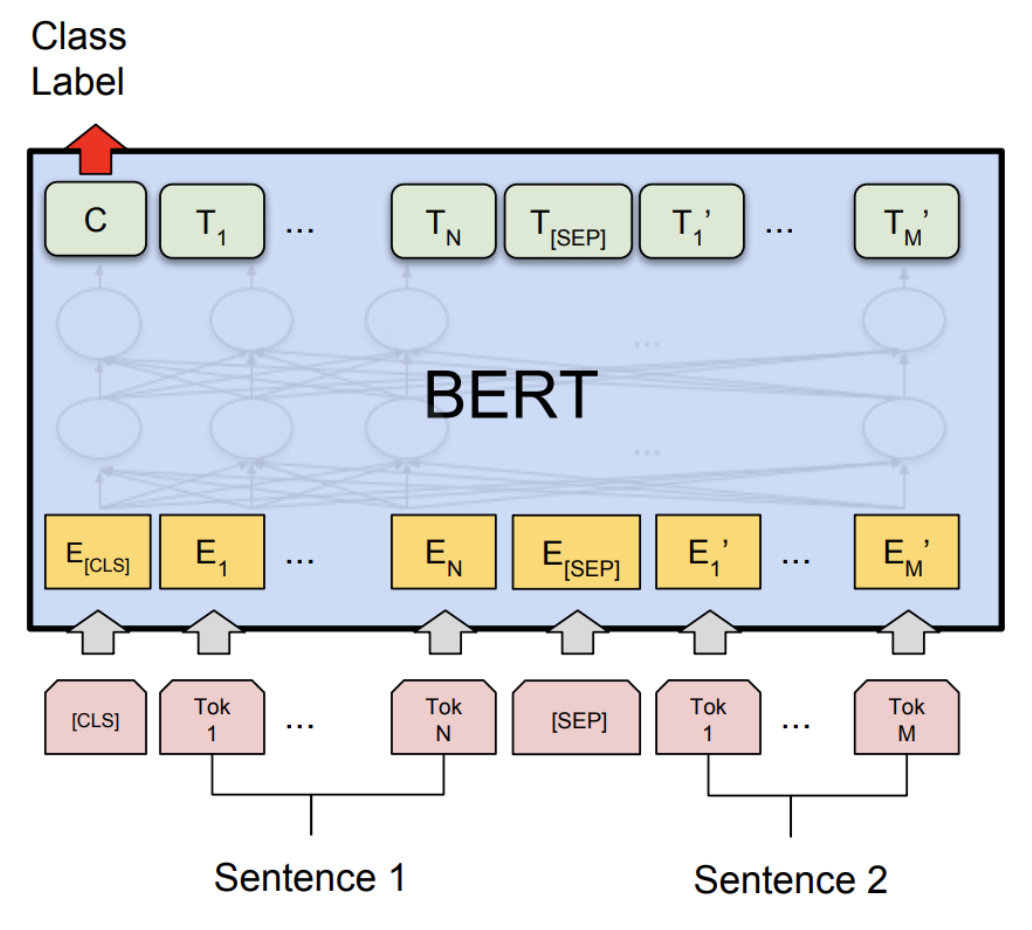

강의 시간에 배웠던 것처럼 BERT는 encoder로만 이루어진 언어 모델입니다. 이러한 BERT를 이용하여 Question Answering task를 수행하려면 어떻게 해야 할까요?

일단 직관적으로 생각해 봅시다.    
context와 question을 봐야 답을 예측할 수 있으므로 model의 input으로는 question과 context가 들어 갈 것입니다.     
강의 시간에 말씀드렸던 대로 BERT에는 `SEP` token과 Segment Embedding이 있으므로 question과 context를 구분해서 넣을 수 있습니다.

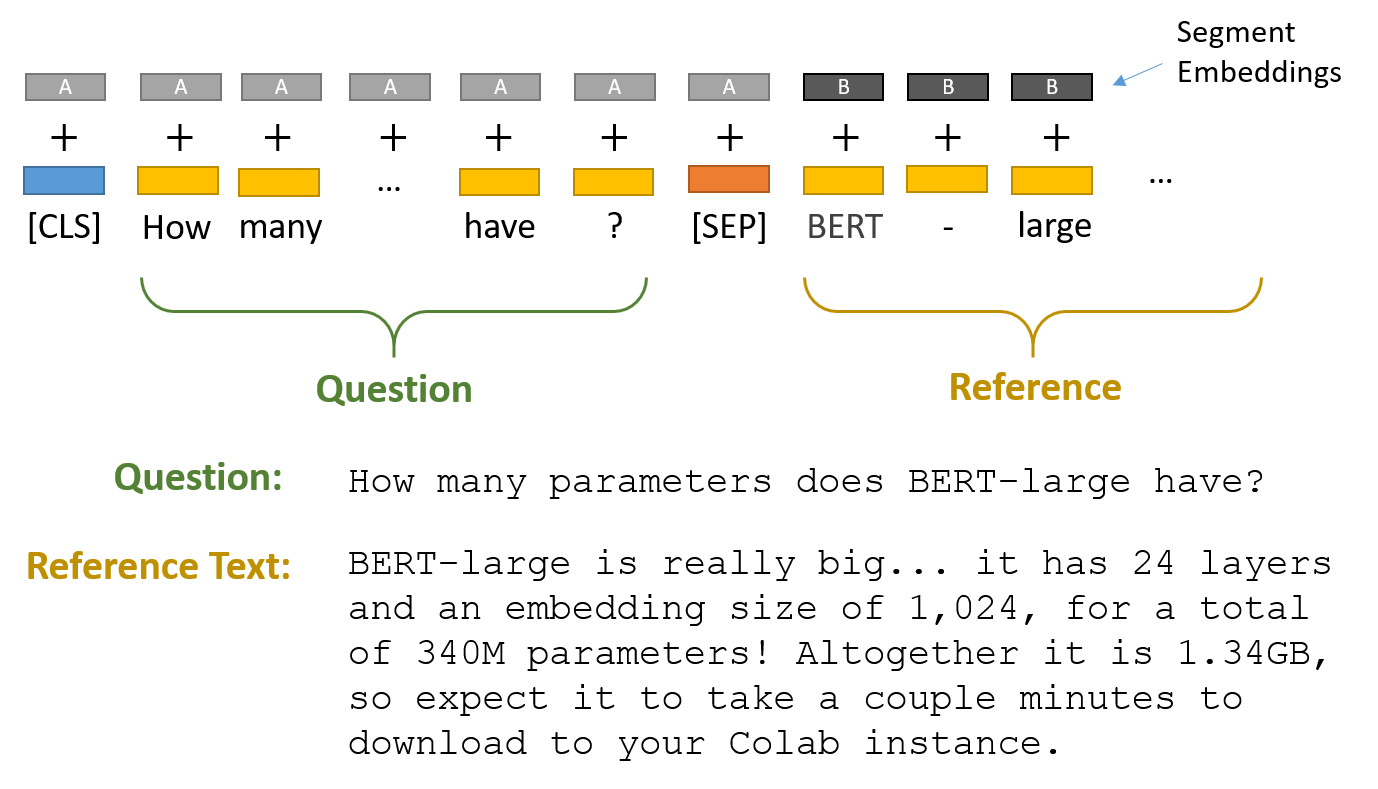

BERT는 encoder-only model이므로 generation에는 약합니다. 그래서 직접 정답을 생성하는 방법으로 모델을 학습시키기에는 무리가 있습니다.   
그 대신, **정답이 시작하는 위치(answer_start)와 끝나는 위치(answer_end)에 있는 token을 예측**하는 방식으로 모델을 학습합니다.

원문: *BERT needs to highlight a “span” of text containing the answer–this is represented as simply predicting which token marks the start of the answer, and which token marks the end.*

그러면 어떻게 정답이 시작하는 위치와 끝나는 위치를 예측할 수 있을까요?

우선, start classifier와 end classifier가 필요합니다. 각 classifier는 단순한 weight set(=vector) 입니다.

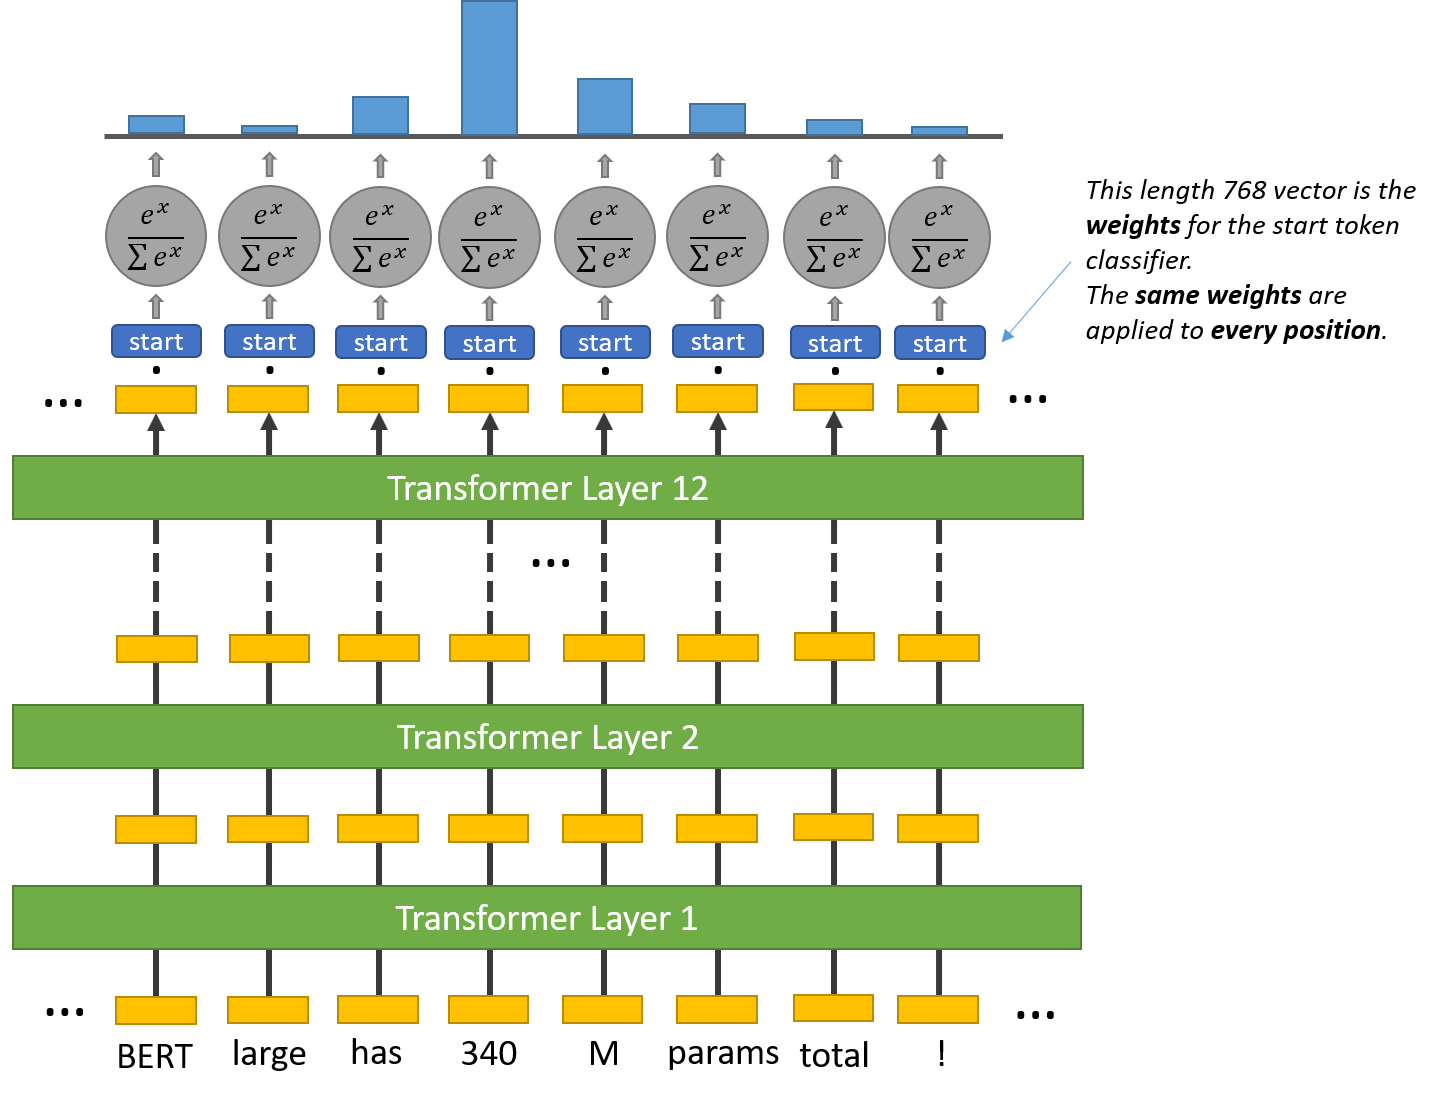

그림처럼 모델의 최종 embedding vectors를 classifier와 내적한 뒤, 나온 결과물에 softmax 함수를 취해줍니다.   
embedding vector 중 softmax 함수를 취했을 때 값이 가장 큰 embedding vector가 정답의 시작점 (answer_start)이 됩니다.

answer_end를 구할 때도 똑같이 하면 되겠죠?

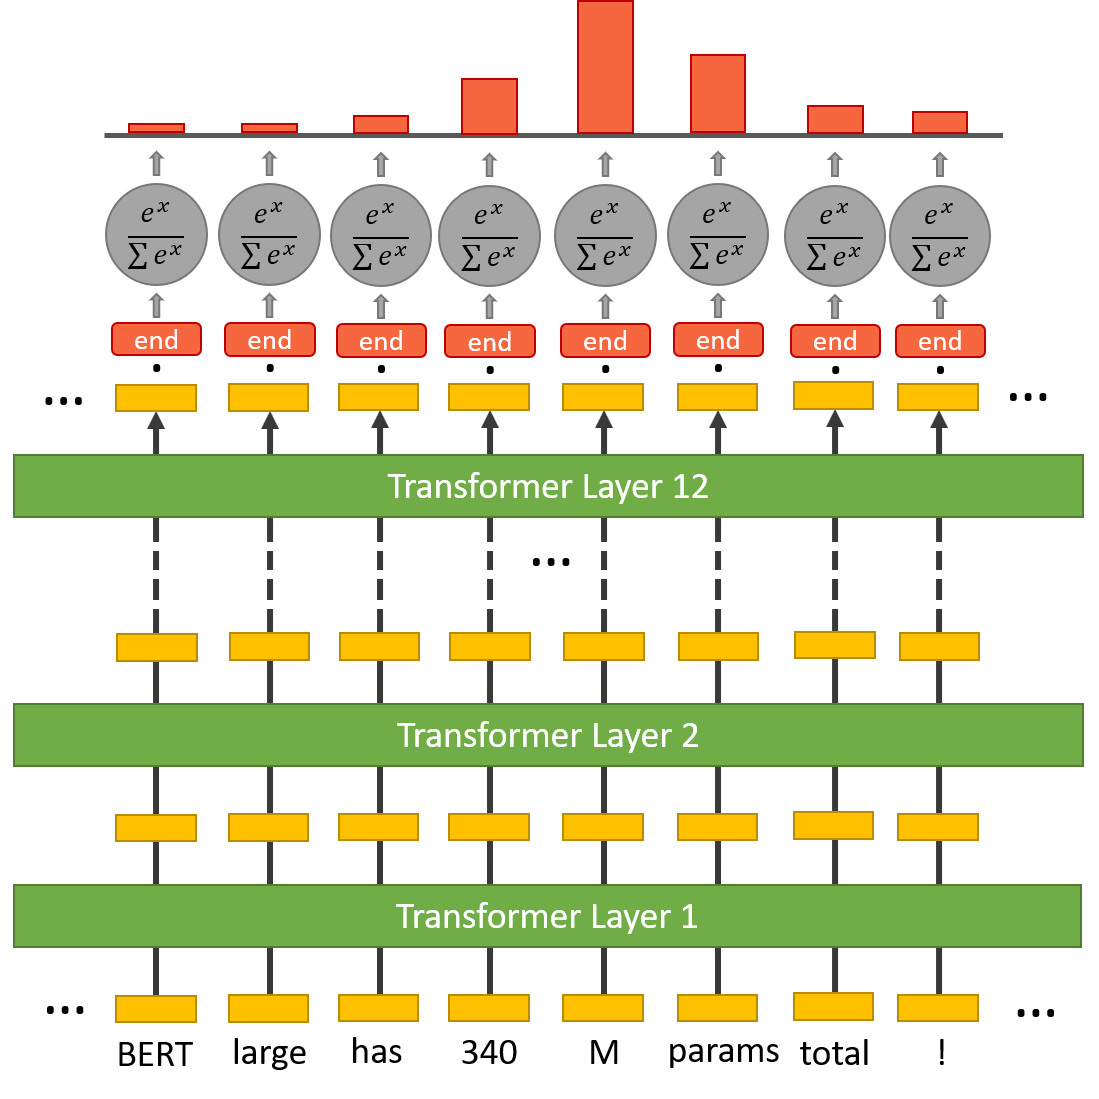

### 문제 1-1.

model의 output embedding을 $h_1, ..., h_T$, start classifier vector를 $s$, 최종 output 값을 $o_1, ..., o_T$라고 합시다.   
위의 notation을 이용하여, model의 i번째 output embedding($h_i$)이 주어졌을 때, 위의 셀에서 설명드린 최종 output($o_i$)을 구하는 과정을 식으로 나타내세요.

※ LateX을 써서 답안을 작성하시면 됩니다.   
LateX을 이용해 수식 쓰는 법: `$$` 사이에 [해당 문서](https://ko.wikipedia.org/wiki/%EC%9C%84%ED%82%A4%EB%B0%B1%EA%B3%BC:TeX_%EB%AC%B8%EB%B2%95)를 참고하여 작성

힌트: embedding과 classifier vector를 내적한 후, softmax 함수를 취해주면 됩니다. 이해가 가지 않으면 [이 문서](https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/#part-1-how-bert-is-applied-to-question-answering)를 참고하세요.

**답:**


이 문장을 지우고 답안을 작성해주시면 됩니다.

### 문제 1-2.
위 설명을 다시 복기해보면, "embedding과 classifier를 내적한 후, softmax 함수를 취해서 나온 최댓값이 정답의 시작점/끝점이 된다" 라고 하고 있습니다.    
여기서 softmax 함수를 취해 최댓값을 구하는 것이 어떤 의미를 가지는지 서술해주세요!

힌트: Image classification task에서도 마지막 feature에서 softmax 함수를 취해 최댓값을 구하죠. 이 과정이 가지는 의미는 무엇이었을까요?

힌트2: softmax 함수의 특징 중 하나는, *해당 함수를 적용한 vector의 모든 원소를 다 더하면 1이다* 입니다.

**답:**

이 문장을 지우고 답안을 작성해주시면 됩니다.

## 3-1. koBERT
저희가 할 task는 한국어 Question Answering이기 때문에, 영어 데이터로 pretrained 된 기존 BERT에서는 성능이 잘 나오지 않습니다. 이 때문에 한국어로 pretrained된 BERT 모델을 가져와 사용할 것입니다.   
SKTBrain에서 **koBERT**라는 이름으로 배포한 모델이 바로 그것입니다.   

자세한 정보는 아래를 참고하세요:   
[koBERT 공식 레포](https://github.com/SKTBrain/KoBERT#korean-bert-pre-trained-cased-kobert)     
[koBERT for Hugging Face](https://github.com/monologg/KoBERT-Transformers)

# 4. Tokenizer

이제 BERT로 QA task에 파인튜닝 하는 과정을 알아봤으니 본격적으로 모델 학습을 해 볼까 합니다. 그러기 위해서는 우리가 가진 데이터를 모델의 input으로 들어갈 수 있도록 몇 가지 처리를 해 주어야 하는데요. 그 중 첫 번째가 tokenize 작업입니다. (강의 시간에 배웠죠?)

koBERT에는 한국어에 맞게 학습된 Tokenizer가 존재합니다.   
기존 BERT 모델의 Tokenizer는 WordPiece 방법을 기반으로 만들어졌지만, koBERT의 Tokenizer는 SentencePiece 알고리즘으로 만들어졌습니다.   

## 4-1. Tokenizer 다뤄보기

그럼, 해당 토크나이저를 불러와서 간단하게 다뤄보겠습니다.   
해당 토크나이저는 Hugging Face에서 지원하는 Tokenizer 모듈을 상속받아 만들어진 것으로, 덕분에 코드 한줄로도 쉽게 pretrained된 tokenizer를 받아올 수 있습니다.

In [ ]:
# koBERT Tokenizer를 불러옵니다.
bert_tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

# __call__ 메소드를 실행해봅시다.
# 이 메소드는 input corpus를 받아 바로 model의 input으로 들어갈 수 있도록 정제하여 리턴해 줍니다.
print(bert_tokenizer("내가 할 일은 아이들이 절벽으로 떨어질 것 같으면 재빨리 붙잡아주는 거야.")['input_ids'])

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


[2, 1435, 4977, 3803, 7086, 3123, 7096, 4067, 6354, 7078, 1856, 6855, 7350, 905, 830, 7083, 3969, 6461, 6122, 2504, 6797, 7280, 862, 6844, 54, 3]


### 문제 2.
수업 시간에 Tokenizer의 pipeline에 대해 배웠습니다.   
Hugging Face의 Tokenizer 클래스의 메소드를 사용하여, 위 `__call__`메소드와 동일한 역할을 하는 함수를 만들어 보세요.

힌트: [공식 문서](https://huggingface.co/docs/transformers/main_classes/tokenizer)를 참고해도 되고, 사실 수업 시간에 이 내용을 이미 다뤘기에 그대로 하시면 됩니다.

In [ ]:
def my_tokenizer(tokenizer, text):
  result = None

  # input text 양 쪽에 [CLS]와 [SEP] token을 붙여줍니다.
  text = "[CLS]" + text + "[SEP]"

  #################################################################################################
  # TODO (1~5 Lines)                                                                              #
  #################################################################################################


  return result

In [ ]:
# Sanity Check
# OK!가 나오면 해당 문제를 통과한 것입니다.

bert_tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
input_str = "내가 할 일은 아이들이 절벽으로 떨어질 것 같으면 재빨리 붙잡아주는 거야."
target = bert_tokenizer(input_str)['input_ids']
source = my_tokenizer(bert_tokenizer, input_str)

print("Result for sanity check...")
for i in range(len(target)):
  if source[i] > target[i]:
    print("Error!")
    break
else:
  print("OK!")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


Result for sanity check...
OK!


## 4-2. Tokenizer for batch

실제로 모델에서 학습을 할 때는 batch 단위로 input이 들어오게 됩니다. 그렇기에 tokenizer에서도 여러 data를 받아 처리할 수 있게 구현이 되어 있습니다.

하지만 데이터마다 각각의 sequence 길이가 다르기 때문에 이를 맞춰주기 위해  **padding** 작업을 해야만 합니다.   
Hugging Face의 Tokenizer에서는 이를 지원하고 있습니다.

자세한 사항은 [공식 문서](https://huggingface.co/docs/transformers/main_classes/tokenizer)의 PretrainedTokenizer > `__call__`을 참조하세요.

In [ ]:
corpus = ["내가 할 일은 아이들이 절벽으로 떨어질 것 같으면, 재빨리 붙잡아주는 거야.",
          "애들이란 앞뒤 생각 없이 마구 달리는 법이니까 말이야.",
          "그럴 때 어딘가에서 내가 나타나서는 꼬마가 떨어지지 않도록 붙잡아주는 거지.",
          "온종일 그 일만 하는 거야.",
          "말하자면 호밀밭의 파수꾼이 되고 싶다고나 할까.",
          "바보 같은 얘기라는 건 알고 있어.",
          "하지만 정말 내가 되고 싶은 건 그거야.",
          "바보 같겠지만 말이야."]

padding을 할 때 어떤 길이를 기준으로 할 지는 `__call__`의 파라미터를 통해 정할 수 있습니다.

아래 코드는 고정된 길이(20)을 정해두고 tokenizer를 실행하여 각 코퍼스를 병렬적으로 처리하고 있습니다.   
현재 코퍼스가 해당 길이보다 **길면 뒷 부분은 잘리고 (truncated), 짧으면 `[PAD]` token이 남은 부분을 채우게** 됩니다.

In [ ]:
bert_tokenizer(corpus, padding="max_length", max_length=20, truncation=True, return_tensors='pt')['input_ids']

tensor([[   2, 1435, 4977, 3803, 7086, 3123, 7096, 4067, 6354, 7078, 1856, 6855,
         7350,  905,  830, 7083,   46, 3969, 6461,    3],
        [   2, 3194, 5940, 6016, 3184, 5916, 2705, 3283, 1907, 5495, 1601, 5760,
         2322, 7096, 5771, 1963, 6844,   54,    3,    1],
        [   2, 1185, 6042, 1844, 3220, 5952, 5330, 6903, 1435, 1399, 6554,  517,
         5615, 6141, 5330, 1859, 7318, 3154, 2504,    3],
        [   2, 3437, 7268, 7126, 1185, 3803, 6150, 4930,  862, 6844,   54,    3,
            1,    1,    1,    1,    1,    1,    1,    1],
        [   2, 1958, 7818, 6198, 5090, 6267, 6311, 7095, 4799, 6629, 5629, 7096,
         1764, 3072, 5439, 5655, 4977, 5591,   54,    3],
        [   2, 2186, 6364,  833, 3219, 6005,  881, 3168, 3868,   54,    3,    1,
            1,    1,    1,    1,    1,    1,    1,    1],
        [   2, 4946, 4102, 1435, 1764, 3075,  881, 1185, 5377, 6844,   54,    3,
            1,    1,    1,    1,    1,    1,    1,    1],
        [   2, 2186, 6364, 

## 4-3. token_type_ids, attention_mask

하지만 tokenizer에서 `__call__`을 썼을 때는 인코딩 된 결과물이 아니라 **dictionary 타입의 Object**가 리턴이 됩니다.

In [ ]:
bert_tokenizer("엥 진짜로?")

{'input_ids': [2, 517, 6915, 4368, 6079, 258, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

`input_ids`외에 `token_type_ids`, `attention_mask`도 리턴이 되는데, input id뿐만 아니라 이 두 tensor도 모델의 학습 / 추론에 꼭 필요합니다.

### 문제 3.
이 두 tensor (`token_type_ids`, `attention_mask`)가 하는 역할은 무엇일까요? 아래에 적어주세요!

힌트: [Tokenizer 공식 문서](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer) 의 Returns 항목을 참조하세요. 구글링을 하셔도 됩니다.

힌트2: `token_type_ids`는 BERT의 Segment Embeddings와 연관이 있습니다.   
`attention_mask`는 4-2의 padding과 연관이 있습니다.

**답:**

`token_type_ids`: 여기에다 답을 적어주세요

`attention_mask`: 여기에다 답을 적어주세요

## 4-4. 데이터셋 수정
기존 데이터셋에 있는 `answer_start`는 sequence의 **글자**를 기준으로 정답이 시작하는 위치를 알려줍니다. 하지만 저희가 필요한 건 **sequence token**을 기준으로 한, 정답 token들(span)의 (시작 index, 종료 index) 입니다.

그러므로 주어진 데이터를 받았을 때, 정답 시작 token과 끝 token의 index를 리턴해주는 작업이 추가적으로 필요합니다.    
아래는 해당 작업을 수행하는 함수 `get_span_index` 코드입니다. 실행시켜주세요.

In [ ]:
def get_span_index(df, tokenizer):
  context = list(df["context"])
  question = list(df["question"])
  answer = list(df["answer"])
  answer_idx = list(df["answer_start"])
  answer_start = []
  answer_end = []

  for c, q, a, i in zip(context, question, answer, answer_idx):
    # c_ids = tokenizer(c, add_special_tokens=False, return_tensors='pt')["input_ids"][0]
    c_truncated_ids = tokenizer(c[:i], add_special_tokens=False, return_tensors='pt')["input_ids"][0]
    # print(c_ids)
    q_ids = tokenizer(q, return_tensors='pt')["input_ids"][0]
    a_ids = tokenizer(a, add_special_tokens=False, return_tensors='pt')["input_ids"][0]

    answer_start.append(q_ids.size(0) + c_truncated_ids.size(0))
    answer_end.append(q_ids.size(0) + c_truncated_ids.size(0) + a_ids.size(0) - 1)
    # print(q_ids)
    # print(a)
    # print(a_ids)

  return answer_start, answer_end

In [ ]:
answer_start, answer_end = get_span_index(train, bert_tokenizer)

구한 `answer_start`와 `answer_end` list를 dataframe의 새로운 column으로 추가시켜줍시다.

In [ ]:
train.drop(['answer_start'], axis=1, inplace=True)
train['answer_start'] = answer_start
train['answer_end'] = answer_end
train.head()

,question,context,answer,answer_start,answer_end
0,바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,교향곡,56,58
1,바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,1악장,251,253
2,바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,베토벤의 교향곡 9번,135,143
3,1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,파우스트,31,33
4,파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,합창교향곡,221,225


# 5. DataSet / DataLoader

우리가 가진 KorQuAD 데이터셋을 모델에게 넣어줄 수 있도록 정제해 봅시다. pytorch에서는 이 작업을 용이하게 하기 위해 `DataSet`과 `DataLoader` 클래스를 지원하는데요. 이미 저번 과제들에서 다뤘기에 익숙하리라고 생각하여, 이에 대한 자세한 설명은 생략하도록 하겠습니다.

## 5-1. Dataset

### 문제 4.
저희는 위에서 배운 대로, input text를 tokenize 하여 모델에게 넣어줄 예정인데요.      
여태까지 배웠던 내용을 생각하며 아래 DataSet class를 정의하는 코드를 완성해 주세요!

In [ ]:
class KorquadDatasetForBERT(Dataset):
    def __init__(self, df, tokenizer, max_length=512, inference=False):
        # parameter 설명:
        # df (pandas DataFrame) : Dataset
        # tokenizer: tokenizer
        # max_length (int): tokenizer의 max_length parameter에 들어갈 값
        # inference (bool): false일 경우 training, true일 경우 inference

        self.question = list(df["question"])
        self.context = list(df["context"])
        self.answer = list(df["answer"])
        self.answer_start =  list(df["answer_start"]) if not inference else None
        self.answer_end = list(df["answer_end"]) if not inference else None

        self.tokenizer = tokenizer
        self.max_length = max_length
        self.inference = inference

        #################################################################################################
        # TODO: 아래 코드는 input sequence를 토큰화하는 코드입니다. 빈 파라미터를 채워주세요.           #
        # Hint: input text는 pair로 들어갈 수도 있답니다.                                               #
        # (token_types_id를 잘 찾아보신 분들은 아셨을 거예요.)                                          #
        #################################################################################################
        input_tokens = self.tokenizer(###채워 주시면 됩니다###, padding="max_length", max_length=self.max_length, truncation=True, return_tensors='pt')
        self.input_ids = input_tokens['input_ids']
        self.token_types_id = input_tokens['token_type_ids']
        self.input_mask = input_tokens['attention_mask']

    def __len__(self):
        return len(self.question)

    def __getitem__(self, idx):
        if not self.inference:
          return self.input_ids[idx], self.token_types_id[idx], self.input_mask[idx], self.answer_start[idx], self.answer_end[idx]
        else:
          return self.input_ids[idx], self.token_types_id[idx], self.input_mask[idx]

## 5-2. Custom DataSet/DataLoader 호출 및 train/validation dataset 분할

train 데이터셋을 불러와 방금 정의한 DataSet 객체 안에 저장해 봅시다.

※ 해당 작업은 실행 환경에 따라 시간이 꽤 걸릴 수도 있습니다.   
  그리고 실행 중 화면 버벅임과 같은 현상이 발생할 수도 있으니 실행 후 가만히 기다리시는 것을 권장합니다.

In [ ]:
# train dataset 호출
dataset = KorquadDatasetForBERT(train, bert_tokenizer)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

모델을 학습할 때는 보통 모델이 과적합(overfitting)되었는지 판단하기 위해 train dataset 중 일부를 떼내어 검증(validation) 데이터셋으로 사용합니다.    
아래의 함수는 데이터셋을 넣었을 때, 특정 비율로 train과 validation 데이터셋을 분리하여 리턴해주는 함수입니다. 실행해보세요!

In [ ]:
def dataset_split(dataset, ratio):
    train_size = int(ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

데이터 셋을 train과 validation set으로 분리한 후 이를 DataLodaer에 담아 봅시다.

batch_size는 기본적으로 16으로 설정해 두었습니다만, batch size를 늘리거나 줄여보면서 학습의 성능을 비교해 보시는 것도 좋을 것 같습니다! (다만, 무료 colab의 경우 batch size가 너무 커지면 가끔 감당 못하는 불상사가 생기기도 하니, 64 이상은 지양해 주심이...)

In [ ]:
batch_size = 16 # 자신의 현재 GPU 성능에 맞게 조절해 주세요.

train_dataset, val_dataset = dataset_split(dataset, 0.8)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# 문제 4 Sanity Check
# 아래 코드를 실행해서 OK!가 출력되면 통과
# batch size를 다르게 한 경우 TODO2 check에서 에러가 날 수도 있습니다. 그래도 그대로 넘어가 주시면 됩니다.

gt_ids = torch.tensor([   2, 2186, 5538, 5691, 5760, 1101, 7618, 7095, 4799, 7005, 6691, 6116,
         3824, 5439, 2095, 6884, 7088, 3084, 5439, 7147, 5017, 5760, 5330,  258,
            3,  547,  155, 5712, 2186, 5538, 5691, 5760, 1101, 7618, 7095, 4799,
         7005, 6691, 7088, 4468, 3824, 5439, 1185, 1449, 6896, 1917, 7096,  517,
         5644, 6060, 3686, 2846, 6079, 5007, 4928, 7095, 1103, 7886, 5443, 7088,
         3084, 6062, 1873,  825, 5760, 5782,   54, 3647, 2965, 2186, 5538, 5691,
         5760,  547,  154, 5719, 2553, 1725, 7448, 7078, 2640, 7207, 6629, 7213,
         1562,  517,    0, 7086, 2693, 6003, 4211, 7217, 5468, 3039, 6896,  745,
         7877, 2016, 7768, 7628, 7717, 6053, 6116, 1933, 5760, 4799, 7005, 6691,
         7095, 3063, 6896, 1025, 7870, 4965,   54, 1864, 4799, 6122, 6903, 3093,
         6432, 5702, 7565, 7095, 4348, 6079, 4799, 6122, 3610, 7020, 1073, 7903,
         6811, 5788, 7096, 3332, 7276, 7794, 2333, 7628, 6347, 7095, 1103, 7886,
         5443,  627, 6328, 7088, 1800, 1338,  784, 6209, 2229, 5761,   46, 3650,
         7096, 3647, 5941, 7848,  529, 7034, 4799, 7005, 6691, 7095, 2718, 5443,
         7078, 3084, 6916, 7344, 3647, 3940, 6896, 4164, 7104, 3393, 1369, 7444,
         7074, 6122, 6005,  910, 3632, 7836, 3298, 7319, 3273,   54, 3301, 7095,
         1875, 5788, 7253, 4177, 7095,  968, 6901, 1214, 4015, 6896, 3996, 7899,
         3860,  920, 1591, 7828, 4117, 7202, 4909, 6079, 5655, 3036, 7095, 5330,
         2216, 5899,  912, 3101, 2333, 7628, 6347, 7095, 4984, 7402, 5488, 7886,
         5443, 4177, 7095, 3393, 2232,  911, 2417, 2872, 3862,   54, 1204, 1103,
         7886, 5443, 3932, 7088,  547,  155, 5717,  606, 5719,  894, 4799, 6122,
         6903, 4423, 7876,  529, 6811, 7187, 3086, 1783, 6896, 4261, 7869,   54,
         1864, 3940, 7095, 3460, 5468, 1751, 1191, 3647, 2718, 5443,   20, 6811,
         7178,   40, 7088, 4799, 6122, 3610, 7026, 3332, 7276, 7953, 6903, 3332,
         7276, 7836, 4799, 7659, 6364, 5592, 4249, 7782, 6944, 7075,   46, 3050,
         5760, 3676, 6855, 7318, 7327, 3157,   54,  940, 4501, 6928, 7086,  605,
         5712, 2207, 7096, 4304, 5176, 6896, 1796, 5854, 6903, 3332, 7276, 5895,
         5439, 3969, 6928, 5859, 3676, 6855, 7252,   46, 3756, 6896, 1192, 2267,
         7483, 5887, 1958, 6828,   54, 1185, 2620, 1191, 1900, 6909, 7483, 6983,
         2267, 7951, 7794, 1469, 5843, 6016, 5920, 7119, 7088, 3460, 7788, 4707,
         7925, 7096, 7199, 6901, 4423, 7794, 1815, 2468, 7276, 7828, 2963, 2355,
         5686, 5761,   46, 1201, 2186, 6489, 2717, 7096, 3647, 1013, 7088,  517,
         7145, 5400, 4955,  912, 3105, 5330, 4930, 3618, 5859, 3862,   54,    3,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1])
gt_token_types_id = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0])

input_ids, token_types_id, _, _, answer_end = dataset[0]

print("Sanity check...")
# print("TODO1: ", end='')
# if answer_end == 86:
#   print("OK!")
# else:
#   print("Error!")
print("TODO2: ", end='')
if torch.equal(input_ids, gt_ids) and torch.equal(token_types_id, gt_token_types_id):
  print("OK!")
else:
  print("Error!")

Sanity check...
TODO2: OK!


# 6. 모델 학습

이제 대망의 모델 학습 시간입니다!

## 6-1. 모델 불러오기

Hugging Face에서는 토크나이저 외에 pretrained된 모델도 간단하게 불러올 수 있습니다.      
`Transformer` 모듈에서는 특별히 BERT backbone 위에 answer start/end classifier가 부착된 형태의 모델을 `BertForQuestionAnswering`이라는 클래스로 구현해 제공하고 있습니다. 이를 이용하여 저희가 사용할 모델을 불러와봅시다.

In [ ]:
bert_model = BertForQuestionAnswering.from_pretrained('monologg/kobert')
# bert_tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
# 과제를 중간에 다시 시작해서 tokenizer를 정의하지 않았다면 위 코드를 실행시켜 주세요.

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 6-2. 모델 학습

다음으로는 train을 위한 train 기본 정보 설정 및 본격적인 train 단계입니다.

Pytorch 모델 학습 과정도 이미 이전 과제들로부터 숙지가 어느 정도 되었다고 가정하였기 때문에 자세한 설명은 하지 않겠습니다.

1 epoch당 대략 15분~18분 정도가 소요됩니다. 단, 1 epoch만 훈련시킨 모델은 성능이 많이 떨어질 수 있습니다. 따라서 **시간적 여유를 갖고** 최소 3 epoch 이상 훈련해 보시는 것을 추천드립니다.


In [ ]:
logger = logging.getLogger()  ###진행 과정에서 로깅 포인트가 발생할 경우 로깅을 하기 위한 코드입니다. 수정하실 필요 없습니다
logger.setLevel(logging.INFO)  ###진행 과정에서 로깅 포인트가 발생할 경우 로깅을 하기 위한 코드입니다. 수정하실 필요 없습니다

# Config
epochs = 2  # 2-3에폭이 가장 적당. 그보다 더 수행하면 오버피팅 되는 것 같습니다.
warmup_ratio = 0.1
learning_rate = 3e-5
grad_clip = 1.0
train_log_interval = 500 ##train이 100번 이루어질 때마다 logging되도록 한 코드입니다
# validation_interval = 1000 ##1000번의 train이 끝날 때마다 validation을 수행
save_interval = 1000 ##save point는 1000번의 train

# optimizer
param_optimizer = list(bert_model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(
        nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, correct_bias=False)

# scheduler
data_len = len(train_dataloader)
num_train_steps = int(data_len / batch_size * epochs)
num_warmup_steps = int(num_train_steps * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


train에 대한 정보 설정이 끝났으면, 본격적으로 학습을 진행해 봅시다!

### 문제 5.
아래 train 함수의 빈 칸을 채워주세요.

In [ ]:
# logging data info : logging 정보를 지정된 로깅 포인트마다 제시해 주도록 하는 코드입니다.
logging.info(f'data length {data_len}')
logging.info(f'num_train_steps : {num_train_steps}')
logging.info(f'num_warmup_steps : {num_warmup_steps}')


#하드웨어 가속기에 따라 device 값을 설정해주는 코드입니다. 따로 수정하실 필요 없습니다!
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def _validate( #학습 시 검증을 위한 것입니다.
        model: BertForQuestionAnswering,
        dev_dataloader: DataLoader,
        device: torch.device,
        logger: logging.Logger,
        global_step: int,
):
    model.eval()  # 모델을 평가 모드로 전환합니다.
    loss_list = []
    for batch_data in tqdm(dev_dataloader, desc="[EVAL]"):
        with torch.no_grad():
            input_ids, token_type_ids, input_mask, answer_start, answer_end = batch_data

            # 모델의 input들을 device(GPU)와 호환되는 tensor로 바꿔줍니다.
            input_ids = input_ids.to(device)
            token_type_ids = token_type_ids.to(device)
            input_mask = input_mask.to(device)
            answer_start = answer_start.to(device)
            answer_end = answer_end.to(device)

            #################################################################################################
            # TODO: 아래 model_outputs 변수는 model이 예측한 값을 저장하는 변수입니다.                      #
            # 빈 칸을 채워주세요.                                                                           #
            # 조건: 위 batch_data에서 받아온 모든 변수들을 다 사용해야 합니다.                              #
            # 자세한 사항은 hugging face의 BertForQuestionAnswering 문서를 참고하세요.                      #
            # https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForQuestionAnswering #
            #################################################################################################
            model_outputs =

            loss_list.append(model_outputs.loss.item())

    mean_loss = np.mean(loss_list)
    logger.info(f"[EVAL] global_step:{global_step} loss:{mean_loss:.4f} perplexity:{math.exp(mean_loss):.4f}")
    model.train()

    return mean_loss

def bert_train(model, optimizer, scheduler, train_dataloader, val_dataloader, device):
    model.to(device)  # 모델 학습을 설정된 device (CPU, cuda) 위에서 진행하도록 하는 코드입니다.
    model.train() # 모델을 학습 모드로 전환합니다.
    loss_list_between_log_interval = []
    for epoch_id in range(epochs):
        for step_index, batch_data in tqdm(enumerate(train_dataloader), f"[TRAIN] Epoch:{epoch_id+1}", total=len(train_dataloader)):
                global_step = len(train_dataloader) * epoch_id + step_index + 1
                optimizer.zero_grad()

                input_ids, token_type_ids, input_mask, answer_start, answer_end = batch_data

                # 모델의 input들을 device(GPU)와 호환되는 tensor로 바꿔줍니다.
                input_ids = input_ids.to(device)
                token_type_ids = token_type_ids.to(device)
                input_mask = input_mask.to(device)
                answer_start = answer_start.to(device)
                answer_end = answer_end.to(device)

                model_outputs = model(
                    input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=input_mask, \
                    start_positions=answer_start, end_positions=answer_end
                )

                loss = model_outputs.loss
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                scheduler.step()

                # for logging
                loss_list_between_log_interval.append(model_outputs.loss.item())

                #if global_step % train_log_interval == 0:
        mean_loss = np.mean(loss_list_between_log_interval)
        logger.info(
            f"EP:{epoch_id} global_step:{global_step} "
            f"loss:{mean_loss:.4f} perplexity:{math.exp(mean_loss):.4f}"
        )
        loss_list_between_log_interval.clear()

                # if global_step % validation_interval == 0:
        dev_loss = _validate(model, val_dataloader, device, logger, global_step)

        #print("saving model...")
        state_dict = model.state_dict()
        model_path = os.path.join('/content/drive/MyDrive/ML/my_AIKU/DeepIntoDeep/checkpoints', f"kobert_epoch_{epoch_id}.pth")
        logger.info(f"global_step: {global_step} model saved at {model_path}")
        torch.save(state_dict, model_path)

    return model

INFO:root:data length 1511
INFO:root:num_train_steps : 472
INFO:root:num_warmup_steps : 47


train 함수를 실행시켜 모델을 학습시켜 봅시다.

In [ ]:
bert_model = bert_train(bert_model, optimizer, scheduler, train_dataloader, val_dataloader, device)

[TRAIN] Epoch:1: 100%|██████████| 1511/1511 [09:06<00:00,  2.76it/s]
INFO:root:EP:0 global_step:1511 loss:2.4240 perplexity:11.2907
[EVAL]: 100%|██████████| 378/378 [00:43<00:00,  8.65it/s]
INFO:root:[EVAL] global_step:1511 loss:1.8853 perplexity:6.5882
INFO:root:global_step: 1511 model saved at /content/drive/MyDrive/ML/my_AIKU/DeepIntoDeep/checkpoints/kobert_epoch_0.pth


saving model...


[TRAIN] Epoch:2: 100%|██████████| 1511/1511 [09:06<00:00,  2.76it/s]
INFO:root:EP:1 global_step:3022 loss:1.7680 perplexity:5.8594
[EVAL]: 100%|██████████| 378/378 [00:43<00:00,  8.67it/s]
INFO:root:[EVAL] global_step:3022 loss:1.7911 perplexity:5.9962
INFO:root:global_step: 3022 model saved at /content/drive/MyDrive/ML/my_AIKU/DeepIntoDeep/checkpoints/kobert_epoch_1.pth


saving model...


[TRAIN] Epoch:3: 100%|██████████| 1511/1511 [09:07<00:00,  2.76it/s]
INFO:root:EP:2 global_step:4533 loss:1.4911 perplexity:4.4420
[EVAL]: 100%|██████████| 378/378 [00:43<00:00,  8.67it/s]
INFO:root:[EVAL] global_step:4533 loss:1.7623 perplexity:5.8257
INFO:root:global_step: 4533 model saved at /content/drive/MyDrive/ML/my_AIKU/DeepIntoDeep/checkpoints/kobert_epoch_2.pth


saving model...


[TRAIN] Epoch:4: 100%|██████████| 1511/1511 [09:06<00:00,  2.76it/s]
INFO:root:EP:3 global_step:6044 loss:1.2598 perplexity:3.5245
[EVAL]: 100%|██████████| 378/378 [00:43<00:00,  8.66it/s]
INFO:root:[EVAL] global_step:6044 loss:1.8605 perplexity:6.4272
INFO:root:global_step: 6044 model saved at /content/drive/MyDrive/ML/my_AIKU/DeepIntoDeep/checkpoints/kobert_epoch_3.pth


saving model...


[TRAIN] Epoch:5: 100%|██████████| 1511/1511 [09:07<00:00,  2.76it/s]
INFO:root:EP:4 global_step:7555 loss:1.0892 perplexity:2.9720
[EVAL]: 100%|██████████| 378/378 [00:43<00:00,  8.66it/s]
INFO:root:[EVAL] global_step:7555 loss:1.9995 perplexity:7.3853
INFO:root:global_step: 7555 model saved at /content/drive/MyDrive/ML/my_AIKU/DeepIntoDeep/checkpoints/kobert_epoch_4.pth


saving model...


# 7. Inference Evaluation

이로써 모델 학습이 다 완료되었습니다!

## 7-1. Inference

하나의 예시로, 모델의 성능을 대략 예측해 봅시다! input_text에 한 문단 정도의 길이인 text를 넣어 주세요. (짧아도 괜찮습니다) 이 input_text에 대해서 제대로 된 질문을 생성하는지 확인해 봅시다!

In [ ]:
text = "쵸비의 플레이 스타일 중 가장 돋보이는 것은 압도적인 라인전 능력이다. 라인전의 가장 대표적인 지표인 CS 수급 능력이 타의 추종을 불허할 정도로 뛰어나다."
question = "라인전의 대표적인 지표는 무엇입니까?"

inputs = bert_tokenizer(question, text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = bert_model(**inputs)

answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()

# print(answer_start_index)
# print(answer_end_index)

predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
answer = bert_tokenizer.decode(predict_answer_tokens, skip_special_tokens=True)

print(f"질문: {question}\n답: {answer}")

질문: 라인전의 대표적인 지표는 무엇입니까?
답: CS 수급 능력


모델이 원하는 결과를 생성해내지 못한다 해도 너무 염려 마세요. 저희는 절반가량의 데이터셋밖에 학습을 시키지 않았고, epoch를 적게 했으니까요.

### 7-2. Evaluation

하나의 예시만 가지고 모델의 성능을 평가할 수는 없겠죠! 학습시킨 모델이, 주어진 test dataset에 대해 만들어낸 결과와, golden answer(이상적인 정답)를 비교해서 과연 모델이 golden answer에 얼마나 근접했는지를 바탕으로 성능을 평가해야 합니다.

Evaluation에는 여러 Metric이 있습니다. CV에서 자주 쓰이는 Metric, NLP에서 자주 쓰이는 Metric에 조금씩 차이가 있으며, NLP Task에서도 Task의 종류에 따라 자주 쓰이는 Metric이 다릅니다. 이번 과제에서는 Text to Text generation에서 자주 쓰이는 F1 Score를 metric으로 사용하였습니다. (강의 시간에도 언급했었죠!)

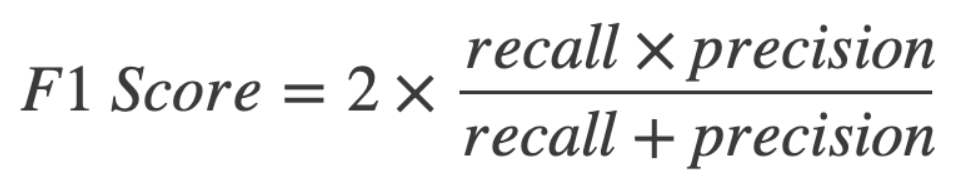

F1 Score는 위와 같이 계산합니다.

(Precision : 모델이 True라고 분류한 것 중 실제로 True인 것의 비율

Recall : 실제로 True인 것에 대해서 모델이 True로 분류한 것의 비율)

직접 변수를 선언하고, 계산하는 방법도 있지만..! 이번 과제에서는 sklearn.metrics 모듈의 f1_score 함수를 선언해서 조금 더 쉬운 방법으로 구해 봅시다 😊

평가에는 아까 만들어 둔 test dataset을 사용할 것입니다. (학습을 train dataset으로 했으니, 겹치지 않는 test dataset을 사용해 봅시다!)

In [ ]:
# 이전에 정의해 둔 test dataset이 여기서 쓰일 차례입니다.
# 불러온 데이터로 dataset과 dataloader를 만들어 줍니다.
test_dataset = KorquadDatasetForBERT(test, bert_tokenizer, inference=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

### 문제 6.
아래는 inference를 수행하는 함수입니다. 빈 칸을 채워 주세요!

In [ ]:
def bert_inference(model, test_dataloader):
  predictions = []

  model.eval()
  for batch in test_dataloader:
    with torch.no_grad():
      input_ids, token_type_ids, input_mask = batch

      # 모델의 input들을 device(GPU)와 호환되는 tensor로 바꿔줍니다.
      input_ids = input_ids.to(device)
      token_type_ids = token_type_ids.to(device)
      input_mask = input_mask.to(device)

      outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=input_mask)
      answer_start_index = outputs.start_logits.argmax(axis=1)
      answer_end_index = outputs.end_logits.argmax(axis=1)

      for i, r in enumerate(input_ids):
        #################################################################################################
        # TODO: answer_start_index와 answer_end_index를 이용하여,                                       #
        # 아래 predict_answer_tokens의 빈 칸을 채워주세요.                                              #
        #################################################################################################
        predict_answer_tokens =

        answer = bert_tokenizer.decode(predict_answer_tokens, skip_special_tokens=True)
        predictions.append(answer)

  return predictions

In [ ]:
# Sanity Check
# OK! 가 나오면 통과

i = 0
answer_start_index = [1]
answer_end_index = [4]
r = [1, 8, 6, 8, 9, 1, 7, 3]
res = # pred_answer_token에 넣은 것과 동일한 식을 넣어주세요.

ans = [8, 6, 8, 9]
for j in range(len(ans)):
  if r[j] > ans[j]:
    print("Error!")
else:
  print("OK!")

dev dataset 대신 validation dataset을 불러와 예측해 봅시다.

In [ ]:
# 모델의 예측값을 받아옵니다.
pred = bert_inference(bert_model, test_dataloader)
print(pred[:10])

['4월', '9월에', '', '25주년', '2017년', '임시배치를', '25주년', '현대자동차', '중국중앙텔레비전', '문재인을 취재하는 청와대 출입 사진기사 2명을 중국 측 경호원들이 과잉 대응하면서 폭행하는 사건이 일어나면서 외교적 결례라는 비판이 나왔다. 사드 언급도 수위가 낮아지긴 했지만 여전히 입장차를 좁히지 못해 공동성']


In [ ]:
# Ground Truth 값을 받아옵니다.
GT = list(test["answer"])
print(GT[:10])

['4월', '9월', '바른정당', '25주년', '2017년', '임시배치', '25주년', '롯데', '중국중앙텔레비전', '청와대 출입 사진기사']


F1 Score를 통해 predictions와 references(GT)를 바탕으로, 우리가 학습시킨 모델의 성능을 평가해 봅시다!

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

def evaluation(tokenizer, preds, gt):
  predicted_tokens = tokenizer(preds, add_special_tokens=False).input_ids
  gt_tokens = tokenizer(gt, add_special_tokens=False).input_ids

  if len(predicted_tokens) != len(gt_tokens):
      print("Error: The lengths of predicted_tokens and gt_tokens are not the same.")
  else:
      #multi-label data를 f1_score에서 지원하지 않으므로, 이진 형식으로 바꿔주기 위해 필요합니다
      mlb = MultiLabelBinarizer()
      predicted_labels = mlb.fit_transform(predicted_tokens)
      gt_labels = mlb.transform(gt_tokens)

      f1 = f1_score(gt_labels, predicted_labels, average = 'micro')

      return f1

In [ ]:
f1 = evaluation(bert_tokenizer, pred, GT)
print("F1 Score:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [0, 1002, 124, 1327, 1501, 1592, 1646, 165, 1655, 192, 2162, 2202, 2408, 2440, 2442, 2547, 2837, 284, 2928, 2949, 3194, 3757, 3784, 3794, 385, 393, 4022, 4032, 4111, 4118, 422, 441, 445, 4481, 4679, 4804, 4894, 4942, 5116, 5182, 5203, 5334, 5379, 5596, 5600, 5625, 5831, 6033, 6051, 6055, 612, 6127, 6201, 6323, 6379, 645, 6467, 6686, 680, 6817, 6914, 693, 6932, 7069, 707, 708, 7166, 7306, 732, 7343, 7438, 7448, 7451, 7677, 7711, 7747, 7761, 7923, 7928, 7966, 840, 985] will be ignored
  warnings.warn(


F1 Score: 0.26758435454087626


3에폭 학습했을 때 기준, 0.26정도 나오는 것을 볼 수 있습니다.

# 8. koBART for Question Generation

앞으로 진행될 task는 기존 task과 연결되지 않으므로, 한 숨 쉬어가실 거면 여기서 끊는 게 합당합니다.    
그 뒤 과제를 이어하실 때는 **1. 준비, 2. 데이터 확인**만 실행하시고 바로 여기로 건너 오시면 됩니다.

다음으로는 encoder-decoder 구조의 모델인 BART를 사용한 task입니다. 앞서 본 BERT는 encoder-only 모델이기 때문에 정답을 생성하는 방법으로 모델을 학습시키기는 어려웠습니다. 그렇다면 encoder-decoder 구조로 이루어진 BART를 학습시킬 때는 어떻게 해야할까요? BART는 입력 텍스트 일부에 노이즈를 추가하여 이를 다시 원문으로 복구하는 autoencoder의 형태로 학습이 됩니다. 주어진 코드를 차근차근 읽으면서 단계를 따라와 주세요! 그리고 코드를 구상하실 때, BART의 구조를 항상 염두에 두고 실행해 주세요 😊

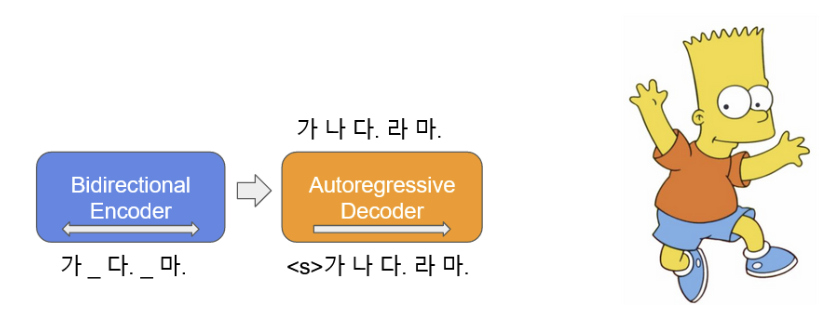

▲위 사진은 한국어 말뭉치로 pre-train 된 koBART 모델의 구조 이해를 돕기 위한 사진입니다. 좀 더 자세히 설명하자면, BART는 bidirectional encoder + autoregressive transformer를 합친 모델입니다. encoder만 존재하는 BERT와 decoder만 존재하는 GPT를 합친 형태라고 보시면 됩니다! 따라서 downstream task에 좀 더 폭넓게 적용될 수 있는 것입니다.

## 9-1. 어떻게 Finetune할까?
일단 Question Generation task를 정의해 보겠습니다.

Input: context    
Output: question

강의 시간에 배웠던 것처럼, context로부터 question을 도출하려면,

- encoder의 input으로 **context**를 넣어주고
- decoder의 input으로 **question**을 넣어 주면 됩니다.

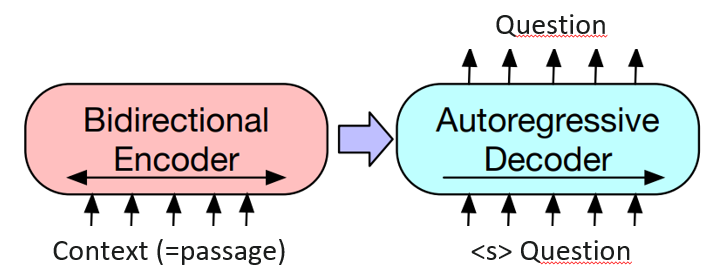

## 9-2. Load the dataset & Pre-processing
###(1) Load the Pre-trained model

이번에는 BERT에서 했던 것과 다르게, custom model class를 정의해 보겠습니다.   
class를 정의하면서, attention mask도 직접 정의해 보려 합니다.

우리가 이번 과제에서 사용할 모델은 한국어 말뭉치에 이미 사전 학습이 된 **kobart** 모델입니다. ([모델 정보](https://huggingface.co/gogamza/kobart-base-v2)) 이를 불러와서 fine-tuning에 사용하기 위해서는, `BartForConditionalGeneration.from_pretrained()`를 통해 불러와야 합니다.

이후에는, 우리가 전처리한 문장들을 tokenize 했을 때, bos token, eos token, sep token을 어떻게 처리할지 지정합니다. (bos - 문장의 시작 토큰, eos- 문장의 끝 토큰, sep - 문장을 분리하는 토큰)

### 문제 7.
또한, class 내의 forward 메서드의 경우, BART에서 forwarding이 어떻게 일어나는지에 주의하면서 빈칸을 채워 주시면 됩니다.

hint : attention mask의 의미와 기능에 주의해 주세요!

hint2: `torch.ne` 함수 정의:  
torch.ne(input, other, *, out=None) → Tensor     
Computes input≠other element-wise.

In [ ]:
class KoBARTConditionalGeneration(nn.Module):
    def __init__(self, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
        super().__init__()
        self.model = BartForConditionalGeneration.from_pretrained('gogamza/kobart-base-v1').to(device)
        self.model.train()
        self.bos_token = '<s>'
        self.eos_token = '</s>'
        self.sep_token = '<unused0>'
        self.device = device

        self.tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-base-v1')
        self.pad_token_id = self.tokenizer.pad_token_id

    def forward(self, input_ids, decoder_input_ids, labels):
        #################################################################################################
        # TODO:                                                                                         #
        # 아래의 빈 칸을 채워주세요.                                                                    #
        #################################################################################################
        attention_mask = input_ids.ne(###).float()  #input_ids.ne()안을 올바르게 채워주세요
        decoder_attention_mask = decoder_input_ids.ne(######).float() #decoder_input_ids.ne()안을 올바르게 채워주세요

        return self.model(input_ids=input_ids.to(self.device),
                          attention_mask=attention_mask,
                          decoder_input_ids=decoder_input_ids.to(self.device),
                          decoder_attention_mask=decoder_attention_mask,
                          labels=labels, return_dict=True)

    def generate(self, *args, **kwargs):
      return self.model.generate(*args, **kwargs)

In [ ]:
# 모델을 불러옵니다.
bart_model = KoBARTConditionalGeneration()

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


### (2) Load the pre-processed data

Fine-tuning 전 마지막 준비 단계입니다!   
encoder input으로 context, output(=label)으로 question을 받아온 후,
`make_decoder_input` 함수를 이용해서 decoder input을 구합니다.

마지막으로, __getitem__ 메서드를 통해 데이터를 생성합니다. 이렇게 생성된 데이터를 통해 모델의 학습이 이루어집니다.

In [ ]:
def make_decoder_input(x, eos_token=1, pad_token=3):
  # Use torch.roll to shift the elements to the right by one place
  x = torch.roll(x, shifts=1, dims=1)

  # Set the first column to </s>
  # 원래는 <s>를 넣어야 하는 게 맞지만 </s>를 넣었을 때 성능이 더 올라감을 실험적으로 보았습니다.
  x[:, 0] = eos_token

  # Check where the value is '3'
  matches = (x == pad_token)

  # Use torch.where to get the indices
  indices = [torch.where(m)[0][0] if m.sum() > 0 else 0 for m in matches]

  for i, index in enumerate(indices):
    x[i, index - 1] = pad_token

  return x

### 문제 8.

여기서 make_decoder_input은 어떻게 동작하는 함수일까요? decoder input의 형식과 연관지어서 설명해 보세요.

Hint: 위의 BART 모델 그림을 참고해 보세요.

**답:**

In [ ]:
class KoBARTQGDataset(Dataset):
    def __init__(self, file, tokenizer, max_length=256):
        self.inputs = list(file['context'].apply(lambda x: f"<s>{x}</s>"))
        self.outputs = list(file['question'].apply(lambda x: f"<s>{x}</s>"))
        self.tokenizer = tokenizer
        # self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        input_tokens = self.tokenizer(self.inputs, padding="max_length", max_length=max_length, truncation=True, return_tensors='pt')
        output_tokens = self.tokenizer(self.outputs, padding="max_length", max_length=max_length, truncation=True, return_tensors='pt')

        self.input_ids = input_tokens['input_ids']
        self.labels = output_tokens['input_ids']
        self.decoder_input_ids = make_decoder_input(self.labels)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.decoder_input_ids[idx], self.labels[idx]

정의된 데이터셋을 사용하여 dataset을 정의해봅시다.

In [ ]:
def dataset_split(dataset, ratio):
    train_size = int(ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

In [ ]:
batch_size = 16 # 자신의 현재 GPU 성능에 맞게 조절해 주세요.

dataset = KoBARTQGDataset(train, bart_model.tokenizer)
train_dataset, val_dataset = dataset_split(dataset, 0.8)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

### (3) Train

다음으로는 train을 위한 train 기본 정보 설정 및 본격적인 train 단계입니다. koBERT와 유사하니 자세한 설명은 생략하겠습니다.

이 모델도 koBERT보다는 작아서, 1 epoch당 대략 8~10분 정도가 소요됩니다. 단, 1 epoch만 훈련시킨 모델은 성능이 많이 떨어질 수 있습니다. 따라서 **시간적 여유를 갖고** 최소 2 epoch 이상 훈련해 보시는 것을 추천드립니다.

In [ ]:
logger = logging.getLogger()  ###진행 과정에서 로깅 포인트가 발생할 경우 로깅을 하기 위한 코드입니다. 수정하실 필요 없습니다
logger.setLevel(logging.INFO)  ###진행 과정에서 로깅 포인트가 발생할 경우 로깅을 하기 위한 코드입니다. 수정하실 필요 없습니다

# Config
epochs = 3
warmup_ratio = 0.1
learning_rate = 3e-5
grad_clip = 1.0
# train_log_interval = 100 ##train이 100번 이루어질 때마다 logging되도록 한 코드입니다
# validation_interval = 1000 ##1000번의 train이 끝날 때마다 validation을 수행
save_interval = 1000 ##save point는 1000번의 train

# optimizer
param_optimizer = list(bart_model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(
        nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, correct_bias=False)

# scheduler
data_len = len(train_dataloader)
num_train_steps = int(data_len / batch_size * epochs)
num_warmup_steps = int(num_train_steps * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

In [ ]:
# logging data info : logging 정보를 지정된 로깅 포인트마다 제시해 주도록 하는 코드입니다.
logging.info(f'data length {data_len}')
logging.info(f'num_train_steps : {num_train_steps}')
logging.info(f'num_warmup_steps : {num_warmup_steps}')


#하드웨어 가속기에 따라 device 값을 설정해주는 코드입니다. 따로 수정하실 필요 없습니다!
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def _validate( #학습 시 검증을 위한 것입니다.
        model: KoBARTConditionalGeneration,
        dev_dataloader: DataLoader,
        device: torch.device,
        logger: logging.Logger,
        global_step: int,
):
    model.eval()  # 모델을 평가 모드로 전환합니다.
    loss_list = []
    for batch_data in tqdm(dev_dataloader, desc="[EVAL]"):
        with torch.no_grad():
            input_ids, decoder_input_ids, labels = batch_data
            model_outputs = model.forward(input_ids, decoder_input_ids, labels)
            loss_list.append(model_outputs.loss.item())

    mean_loss = np.mean(loss_list)
    logger.info(f"[EVAL] global_step:{global_step} loss:{mean_loss:.4f} perplexity:{math.exp(mean_loss):.4f}")
    model.train()

    return mean_loss

def bart_train(model, optimizer, scheduler, train_dataloader, val_dataloader, device):
    model.to(device)  # 모델 학습을 설정된 device (CPU, cuda) 위에서 진행하도록 하는 코드입니다.
    model.train() # 모델을 학습 모드로 전환합니다.
    loss_list_between_log_interval = []
    for epoch_id in range(epochs):
        for step_index, batch_data in tqdm(enumerate(train_dataloader), f"[TRAIN] Epoch:{epoch_id+1}", total=len(train_dataloader)):
                global_step = len(train_dataloader) * epoch_id + step_index + 1
                optimizer.zero_grad()

                input_ids, decoder_input_ids, labels = batch_data
                #print(input_ids)

                model_outputs = model(input_ids, decoder_input_ids, labels)

                loss = model_outputs.loss
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                scheduler.step()

                # for logging
                loss_list_between_log_interval.append(model_outputs.loss.item())

                #if global_step % train_log_interval == 0:
        mean_loss = np.mean(loss_list_between_log_interval)
        logger.info(
            f"EP:{epoch_id} global_step:{global_step} "
            f"loss:{mean_loss:.4f} perplexity:{math.exp(mean_loss):.4f}"
        )
        loss_list_between_log_interval.clear()

                # if global_step % validation_interval == 0:
        dev_loss = _validate(model, val_dataloader, device, logger, global_step)

        #print("saving model...")
        state_dict = model.state_dict()
        model_path = os.path.join('/content/drive/MyDrive/ML/my_AIKU/DeepIntoDeep/checkpoints', f"kobart_epoch_{epoch_id}.pth")
        logger.info(f"global_step: {global_step} model saved at {model_path}")
        torch.save(state_dict, model_path)

    return model

INFO:root:data length 1511
INFO:root:num_train_steps : 283
INFO:root:num_warmup_steps : 28


In [ ]:
bart_model = bart_train(bart_model, optimizer, scheduler, train_dataloader, val_dataloader, device)

[TRAIN] Epoch:1: 100%|██████████| 1511/1511 [06:26<00:00,  3.91it/s]
INFO:root:EP:0 global_step:1511 loss:0.2855 perplexity:1.3304
[EVAL]: 100%|██████████| 378/378 [00:29<00:00, 12.74it/s]
INFO:root:[EVAL] global_step:1511 loss:0.1282 perplexity:1.1368
INFO:root:global_step: 1511 model saved at /content/drive/MyDrive/ML/my_AIKU/DeepIntoDeep/checkpoints/kobart_epoch_0.pth
[TRAIN] Epoch:2: 100%|██████████| 1511/1511 [06:23<00:00,  3.94it/s]
INFO:root:EP:1 global_step:3022 loss:0.1174 perplexity:1.1246
[EVAL]: 100%|██████████| 378/378 [00:29<00:00, 12.77it/s]
INFO:root:[EVAL] global_step:3022 loss:0.1271 perplexity:1.1356
INFO:root:global_step: 3022 model saved at /content/drive/MyDrive/ML/my_AIKU/DeepIntoDeep/checkpoints/kobart_epoch_1.pth
[TRAIN] Epoch:3: 100%|██████████| 1511/1511 [06:23<00:00,  3.94it/s]
INFO:root:EP:2 global_step:4533 loss:0.1051 perplexity:1.1108
[EVAL]: 100%|██████████| 378/378 [00:29<00:00, 12.72it/s]
INFO:root:[EVAL] global_step:4533 loss:0.1296 perplexity:1.1383

# 9-3. Inference & Evaluation

모델에 대해 학습을 진행했으면, 학습의 결과가 잘 나올지 대략적으로 추론(Inference) 해보고, 모델의 성능을 평가하는 것도 아주 중요합니다! 평가 단계가 있는데도, Inference를 하는 이유는 비교적 작고 가벼운 input으로 모델의 성능을 예측할 수 있기 때문입니다! (예시 하나로 바로 대강의 성능을 확인할 수 있으니까요!)

### (1) Inference

하나의 예시로, 모델의 성능을 대략 예측해 봅시다! input_text에 한 문단 정도의 길이인 text를 넣어 주세요. (예시처럼 좀 더 짧아도 괜찮습니다) 이 input_text에 대해서 제대로 된 질문을 생성하는지 확인해 봅시다!

In [ ]:
input_text = "<s>쵸비의 플레이 스타일 중 가장 돋보이는 것은 압도적인 라인전 능력이다. 라인전의 가장 대표적인 지표인 CS 수급 능력이 타의 추종을 불허할 정도로 뛰어나다.</s>"
input_ids = bart_model.tokenizer.encode(input_text, add_special_tokens=True, return_tensors="pt").to(device)
generated_ids = bart_model.generate(input_ids, max_length=50, num_beams=4) #max_length는 임의대로 수정하셔도 됩니다.
generated_text = bart_model.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Generated Text:", generated_text)

Generated Text: 쵸비의 플레이 스타일 중 가장 돋보이는 것은?


Generated Text : 에 제대로 된 질문 형식의 글이 만들어졌나요? 요상한 글이 나왔다고 해도 너무 슬퍼하지 마세요.. 적은 Epoch 수로는 성능에 한계가 있답니다..! GPU가 허락하는 한까지 epoch를 키워봅시다! (그래도 generate가 되어 결과가 나온 것이 뭐라도 있다면..! 제대로 따라오셨을 가능성이 높습니다 😊)

### (2) Evaluation

해당 모델도 koBERT처럼 f1 score로 성능을 평가해 보려고 합니다.
평가 데이터셋으로는 아까 다운받은 dev dataset을 사용해 볼 것입니다!

In [ ]:
# dev dataset 불러오기
with open(os.path.join(DATA_DIR, 'KorQuAD_v1.0_dev.json'), "r", encoding="utf-8") as f:
  dev_loaded_data = json.load(f)
  dev_loaded_data = dev_loaded_data['data']

pre_dev_data = preprocessing(dev_loaded_data)
dev = pd.DataFrame(pre_dev_data)
dev = dev.iloc[:100]  # 평가 데이터셋은 100개만 사용합시다.

input_texts = dev['context'].tolist()
references = dev['question'].tolist()

predictions = []

for input_text in input_texts:
    input_ids = bart_model.tokenizer.encode(input_text, add_special_tokens=True, return_tensors="pt").to(device)
    generated_ids = bart_model.generate(input_ids, max_length=50, num_beams=4)
    generated_text = bart_model.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    predictions.append(generated_text)

In [ ]:
predictions[:10]

['임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 날짜는?',
 '임종석이 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배된 것은 언제인가?',
 '임종석은 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다.',
 '임종석은 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다.',
 '임종석은 1989년 3월 12일 누구의 사전구속영장을 발부받았나?',
 '임종석이 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 것은 언제인가?',
 '임종석이 지명수배된 시기는?',
 '10 헌법학자인 허영 경희대 석좌교수가 헌법개정안 준비 과정에 대해 지적한 것은?',
 '10 헌법학자인 허영 경희대 석좌교수가 헌법개정안 준비 과정에 대해 지적한 것은?',
 '10 헌법학자인 허영 경희대 석좌교수가 헌법개정안 준비 과정에 대해 지적한 것은?']

In [ ]:
references[:10]

['임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?',
 '1989년 6월 30일 평양축전에 대표로 파견 된 인물은?',
 '임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?',
 '임종석을 검거한 장소는 경희대 내 어디인가?',
 '임종석이 조사를 받은 뒤 인계된 곳은 어딘가?',
 '1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 사람의 이름은?',
 '임종석이 1989년 2월 15일에 지명수배 받은 혐의는 어떤 시위를 주도했다는 것인가?',
 '정부의 헌법개정안 준비 과정에 대해서 청와대 비서실이 아니라 국무회의 중심으로 이뤄졌어야 했다고 지적한 원로 헌법학자는?',
 "'행보가 비서 본연의 역할을 벗어난다', '장관들과 내각이 소외되고 대통령비서실의 권한이 너무 크다'는 의견이 제기된 대표적인 예는?",
 '국무회의의 심의를 거쳐야 한다는 헌법 제 몇 조의 내용인가?']

F1 Score를 통해 predictions와 references를 바탕으로, 우리가 학습시킨 모델의 성능을 평가해 봅시다!

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

def evaluation(tokenizer, preds, gt):
  predicted_tokens = tokenizer(preds, add_special_tokens=False).input_ids
  gt_tokens = tokenizer(gt, add_special_tokens=False).input_ids

  if len(predicted_tokens) != len(gt_tokens):
      print("Error: The lengths of predicted_tokens and gt_tokens are not the same.")
  else:
      #multi-label data를 f1_score에서 지원하지 않으므로, 이진 형식으로 바꿔주기 위해 필요합니다
      mlb = MultiLabelBinarizer()
      predicted_labels = mlb.fit_transform(predicted_tokens)
      gt_labels = mlb.transform(gt_tokens)

      f1 = f1_score(gt_labels, predicted_labels, average = 'micro')

      return f1

In [ ]:
f1 = evaluation(bart_model.tokenizer, predictions, references)
print("F1 Score:", f1)

F1 Score: 0.2640466687135401


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [10047, 10256, 10277, 10339, 10396, 10770, 10897, 10948, 10952, 11028, 11040, 11239, 11242, 11265, 11453, 11466, 11712, 11734, 11747, 11846, 11863, 11933, 11940, 11950, 12013, 12037, 12049, 12061, 12126, 12169, 12258, 12700, 12786, 12855, 12869, 13173, 13282, 13360, 13369, 13417, 13447, 13547, 13607, 13619, 13650, 13656, 13710, 13716, 13845, 14033, 14034, 14035, 14045, 14054, 14055, 14057, 14058, 14060, 14063, 14066, 14067, 14081, 14084, 14090, 14091, 14097, 14098, 14104, 14105, 14108, 14124, 14135, 14149, 14154, 14160, 14162, 14167, 14170, 14183, 14186, 14191, 14196, 14219, 14222, 14230, 14240, 14248, 14250, 14259, 14262, 14267, 14269, 14281, 14285, 14289, 14291, 14295, 14312, 14321, 14336, 14348, 14351, 14353, 14361, 14362, 14367, 14385, 14391, 14397, 14408, 14414, 14416, 14418, 14427, 14434, 14435, 14439, 14456, 14461, 14472, 14483, 14500, 14515, 14522, 14524, 14527, 14528, 14

3에폭 기준, 0.26 정도의 값이 나옵니다.

수고 많으셨습니다! 해당 과제의 모든 문제를 풀고, 모든 셀을 다 실행시키셨으면 이 과제를 제출하셔도 됩니다.

> 참고 자료
> - https://github.com/Seoneun/KoBART-Question-Generation
> - https://github.com/HyezNee/LyriKOR (과거의 내 코드,,)